In [2]:
import re, subprocess, os, gzip, json, glob, multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
import tempfile
import pickle
from tqdm import tqdm
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import protein_letters_3to1, is_aa
from Bio.PDB import PDBIO
from scipy.spatial.distance import cdist
import Bio
import Bio.SeqUtils

ModuleNotFoundError: No module named 'Bio'

In [2]:
phmap = {
    'Aromatic': 0,
    'HydrogenDonor': 1,
    'HydrogenAcceptor': 2,
    'PositiveIon': 3,
    'NegativeIon': 4,
    'Hydrophobic': 5
}


index2ph = [    'Aromatic',
    'HydrogenDonor',
    'HydrogenAcceptor',
    'PositiveIon',
    'NegativeIon',
    'Hydrophobic']

In [12]:

def element_fixer(element: str):

    if len(element) > 1:
        element = element[0] + element[1:].lower()
    
    return element


def getfeatures(reclig):
    pocket_cutoff = 8
    
    rec,glig = reclig
    rec = rec.replace('_0.gninatypes','.pdb')            
    m = re.search(r'(\S+)_(\d+)\.gninatypes',glig)
    prefix = m.group(1)
    num = int(m.group(2))
    lig = prefix+'.sdf.gz'
    
    if not os.path.exists(rec):
        print(rec)
    if not os.path.exists(lig):
        print(lig)
        
    with tempfile.TemporaryDirectory() as tmp:
        try:
            if num != 0:
                #extract num conformer
                #avoid chemical parsing for speed reasons
                sdf = gzip.open(lig).read().split(b'$$$$\n')[num]+b'$$$$\n'
                lig = os.path.join(tmp,'lig.sdf')
                with open(lig, 'wb') as out:
                    out.write(sdf)

            phfile = os.path.join(tmp,"ph.json")
            cmd = f'pharmit pharma -receptor {rec} -in {lig} -out {phfile}'
            subprocess.check_call(cmd,shell=True)
            
            #some files have another json object in them - only take first
            #in actuality, it is a bug with how pharmit/openbabel is dealing
            #with gzipped sdf files that causes only one molecule to be read
            decoder = json.JSONDecoder()
            ph = decoder.raw_decode(open(phfile).read())[0]

            if ph['points']:
                feature_coords = np.array([(p['x'],p['y'],p['z']) for p in ph['points'] if p['enabled']])
                feature_kind = np.array([phmap[p['name']] for p in ph['points'] if p['enabled']])
            else:
                feature_coords = []
                feature_kind = []
                
            #extract pocket using Ian's approach
            pdb_struct = PDBParser(QUIET=True).get_structure('', rec)
            if lig.endswith('.gz'):
                with gzip.open(lig) as f:
                    supp = Chem.ForwardSDMolSupplier(f,sanitize=False)
                    ligand = next(supp)
                    del supp
                
            else:
                supp = Chem.ForwardSDMolSupplier(lig,sanitize=False)
                ligand = next(supp)
                del supp

            lig_coords = ligand.GetConformer().GetPositions()
             # get residues which constitute the binding pocket
            pocket_residues = []
            for residue in pdb_struct[0].get_residues():
                # get atomic coordinates of residue
                res_coords = np.array([a.get_coord() for a in residue.get_atoms()])

                # skip nonstandard residues
                is_residue = is_aa(residue.get_resname(), standard=True)
                if not is_residue:
                    continue
                min_rl_dist = cdist(lig_coords, res_coords).min()
                if min_rl_dist < pocket_cutoff:
                    pocket_residues.append(residue)

            atom_filter = lambda a: a.element != "H"
            pocket_atomres = []
            for res in pocket_residues:
                atom_list = res.get_atoms()
                pocket_atomres.extend([(a, res) for a in atom_list if atom_filter(a) ])

            pocket_atoms, atom_residues = list(map(list, zip(*pocket_atomres)))

            pocket_coords = np.array([ar[0].get_coord() for ar in pocket_atomres])
            pocket_elements = np.array([ element_fixer(ar[0].element) for ar in pocket_atomres ])
            pocket_anames = np.array([ar[0].name for ar in pocket_atomres])
            pocket_res = np.array([Bio.PDB.Polypeptide.three_to_index(ar[1].resname) for ar in pocket_atomres])
            pocket_rid = np.array([ar[1].id[1] for ar in pocket_atomres])
            #receptor and features are needed for training
            #glig is included for reference back to original data for debugging
            return ((rec,glig,ligand,(feature_coords, feature_kind),(pocket_coords, pocket_elements, pocket_anames, pocket_res, pocket_rid)))    
        except Exception as e:
            print(e)
            print(rec,glig)
            return((rec,glig,None,None,None))

In [6]:
help(Chem.ForwardSDMolSupplier)

Help on class ForwardSDMolSupplier in module rdkit.Chem.rdmolfiles:

class ForwardSDMolSupplier(Boost.Python.instance)
 |  A class which supplies molecules from file-like object containing SD data.
 |  
 |  Usage examples:
 |  
 |    1) Lazy evaluation: the molecules are not constructed until we ask for them:
 |  
 |       >>> suppl = ForwardSDMolSupplier(file('in.sdf'))
 |       >>> for mol in suppl:
 |       ...    if mol is not None: mol.GetNumAtoms()
 |  
 |    2) we can also read from compressed files: 
 |  
 |       >>> import gzip
 |       >>> suppl = ForwardSDMolSupplier(gzip.open('in.sdf.gz'))
 |       >>> for mol in suppl:
 |       ...   if mol is not None: print mol.GetNumAtoms()
 |  
 |  Properties in the SD file are used to set properties on each molecule.
 |  The properties are accessible using the mol.GetProp(propName) method.
 |  
 |  Method resolution order:
 |      ForwardSDMolSupplier
 |      Boost.Python.instance
 |      builtins.object
 |  
 |  Static methods defin

In [4]:
allinputs = []
for fname in glob.glob('types/it2_tt_v1.3_0_test*types'):
    #pull out good rmsd lines only
    f = open(fname)
    inputs = []
    for line in f:
        label,affinity,rmsd,rec,glig,_ = line.split()    
        if label == '1':
            inputs.append((rec,glig))
    allinputs.append((fname,inputs))

In [5]:
#collect and parse all receptors
receptors = dict()
for fname, inputs in allinputs:
    for rec,lig in tqdm(inputs):
        rec = rec.replace('_0.gninatypes','.pdb')            

        if rec not in receptors:
            receptors[rec] = Chem.MolFromPDBBlock(open(rec).read(),sanitize=False)
            

100%|██████████| 268654/268654 [01:13<00:00, 3637.21it/s] 


In [6]:
with gzip.open('types/receptors.pkl.gz','wb') as recout:
    pickle.dump(receptors,recout)

In [20]:
%%time
pool = multiprocess.Pool()
allphdata = []
for fname, inputs in allinputs:
            
    #get features
    phdata = pool.map(getfeatures,inputs)
    #filter out empty
    phdata = [ex for ex in phdata if ex[2]]
    allphdata += phdata
    #writeout pickle (into types folder)
    outname = fname.replace('.types','_ph.pkl.gz')
    with gzip.open(outname,'wb') as out:
        pickle.dump(phdata,out)

not enough values to unpack (expected 2, got 0)
METF_ECOLI_3_296_0/3fsu_A_rec.pdb METF_ECOLI_3_296_0/3fsu_A_rec_3fsu_c2f_lig_tt_docked_18.gninatypes
not enough values to unpack (expected 2, got 0)
METF_ECOLI_3_296_0/3fsu_A_rec.pdb METF_ECOLI_3_296_0/3fsu_A_rec_3fsu_mry_lig_tt_min_0.gninatypes
not enough values to unpack (expected 2, got 0)
METF_ECOLI_3_296_0/2fmn_B_rec.pdb METF_ECOLI_3_296_0/2fmn_B_rec_3fsu_mry_lig_tt_min_0.gninatypes
not enough values to unpack (expected 2, got 0)
METF_ECOLI_3_296_0/3fsu_A_rec.pdb METF_ECOLI_3_296_0/3fsu_A_rec_2fmn_4hf_lig_tt_min_0.gninatypes
not enough values to unpack (expected 2, got 0)
METF_ECOLI_3_296_0/2fmn_B_rec.pdb METF_ECOLI_3_296_0/2fmn_B_rec_2fmn_4hf_lig_tt_min_0.gninatypes
not enough values to unpack (expected 2, got 0)
DPOL_BPR69_1_903_0/1q9x_A_rec.pdb DPOL_BPR69_1_903_0/1q9x_A_rec_1q9x_dgp_lig_tt_min_0.gninatypes
not enough values to unpack (expected 2, got 0)
DPOL_BPR69_1_903_0/2p5g_A_rec.pdb DPOL_BPR69_1_903_0/2p5g_A_rec_1q9x_dgp_lig_t

In [21]:
sum([len(i[1]) for i in allinputs])

825577

In [27]:
len(allphdata[0][3][1])

2

In [28]:
sizes = [len(ph[3][1]) for ph in allphdata]

Text(0.5, 0, '# Features')

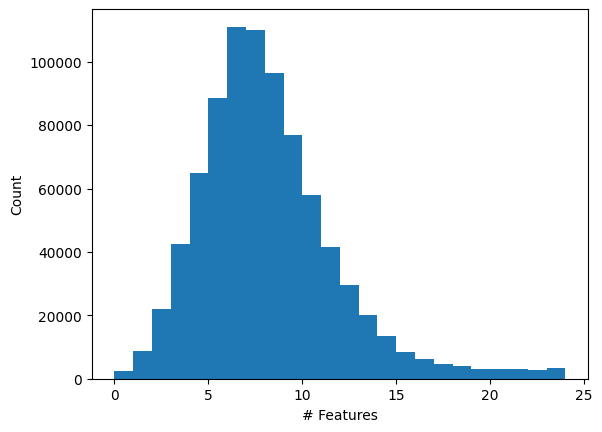

In [29]:
plt.hist(sizes,bins=range(25))
plt.ylabel("Count")
plt.xlabel('# Features')

In [35]:
features = [ph[3][1] for ph in allphdata ]

In [37]:
kinds = [f for feat in features for f in feat]

/tmp/ipykernel_861642/1729506146.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['']+index2ph,rotation=90)


Text(0, 0.5, 'Count')

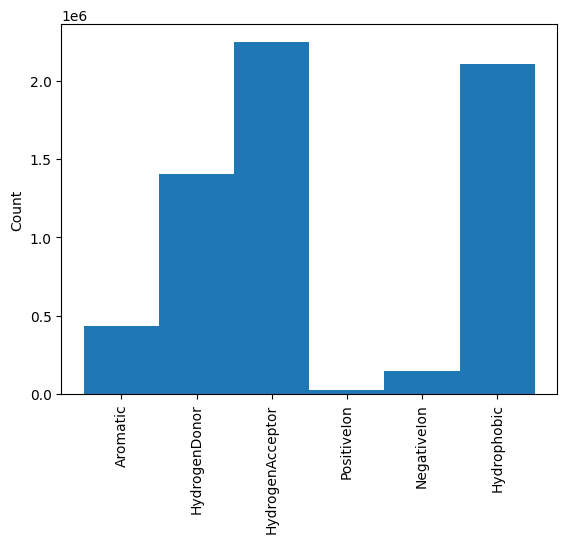

In [38]:
plt.hist(kinds,np.linspace(-0.5,5.5,7))
plt.gca().set_xticklabels(['']+index2ph,rotation=90)
plt.ylabel("Count")

In [39]:
len(kinds)

6357181